In [1]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [4]:
def plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, spk_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(4, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [0.4, 1, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title("Synaptic Conductance-based Neuron Model With Input Spikes")
  ax[0].set_yticks([]) 

  # Plot membrane potential
  ax[1].plot(syn_rec.detach().numpy())
  ax[1].set_ylim([0, 0.5])
  ax[1].set_ylabel("Synaptic Current ($I_{syn}$)")
  plt.xlabel("Time step")

  # Plot membrane potential
  ax[2].plot(mem_rec.detach().numpy())
  ax[2].set_ylim([0, 1.5])
  ax[2].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[2].axhline(y=1, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[3], s=400, c="black", marker="|")
  plt.ylabel("Output spikes")
  ax[3].set_yticks([]) 

  plt.show()

def plot_spk_mem_spk(spk_in, mem_rec, spk_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)
  ax[0].set_yticks([]) 

  # Plot membrane potential
  ax[1].plot(mem_rec.detach())
  ax[1].set_ylim([0, 0.6])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
  ax[2].set_yticks([])
  ax[2].set_ylabel("Output Spikes")

  plt.show()

# Synaptic Conductance-Based LIF Neuron Model
Accounts for the gradual temporal dynamics of neurotransmitter release actually observed in nature.

Requires 2 input arguments, *alpha* (the decay rate of the synaptic current), and *beta* (the decay rate of the membrane potential).

In [2]:
# Define temporal dynamics

alpha = 0.9
beta = 0.8
num_steps = 200

# Initialize 2nd order LIF neuron

lif1 = snn.Synaptic(alpha = alpha, beta = beta)

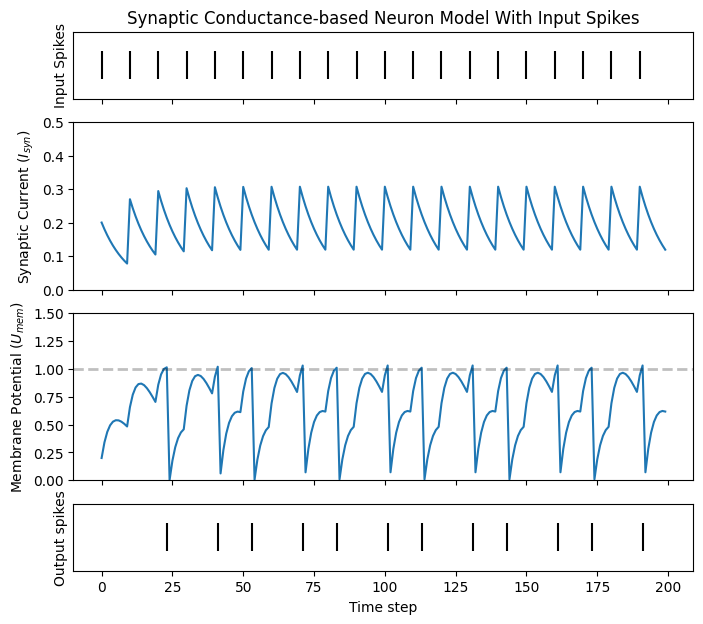

In [8]:
# Create a periodic spiking input of 0.2V

w = 0.2
spk_period = torch.cat((torch.ones(1) * w, torch.zeros(9)), 0)
spk_in = spk_period.repeat(20)

# Initialize hidden states and output

syn, mem = lif1.init_synaptic()
spk_out = torch.zeros(1)
syn_rec = []
mem_rec = []
spk_rec = []

# Simulate neurons

for step in range(num_steps):
    spk_out, syn, mem = lif1(spk_in[step], syn, mem)
    spk_rec.append(spk_out)
    syn_rec.append(syn)
    mem_rec.append(mem)
    
spk_rec = torch.stack(spk_rec)
syn_rec = torch.stack(syn_rec)
mem_rec = torch.stack(mem_rec)

plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, spk_rec, "Synaptic Conductance-Based Neuron Model with Input Spikes")

# Alpha Neuron Model
A recursive version of the Spike Response Model which uses a convolutional filter lto compute the membrane potential response.

In this example Umem is defined by the sum of two exponentials, with *alpha* as the decay rate of the positive exponential and *beta as the decay rate of the negative exponential.

This is also a cool way to account for both excitation and inhibition.

In [20]:
alpha = 0.8
beta = 0.7

# Initialize neuron

lif2 = snn.Alpha(alpha = alpha, beta = beta, threshold = 0.5)

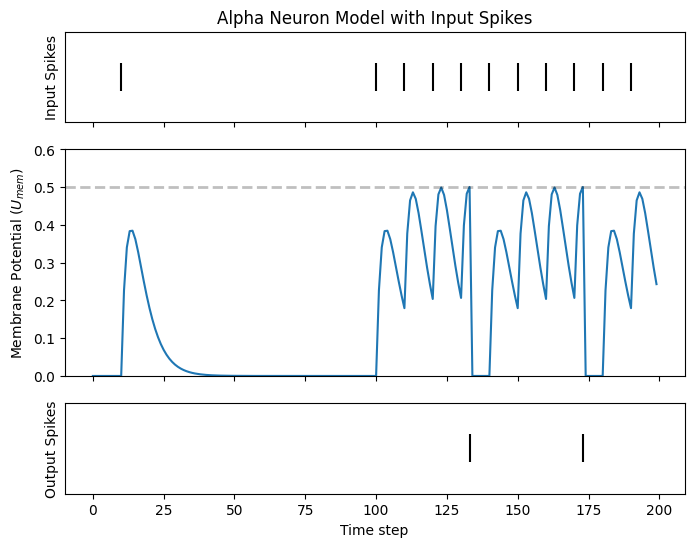

In [21]:
# Input spike - initial spike followed by periodic spiking

w = 0.85
spk_in = (torch.cat((torch.zeros(10), torch.ones(1), torch.zeros(89),
                     (torch.cat((torch.ones(1), torch.zeros(9))).repeat(10))), 0) * w).unsqueeze(1)

syn_exec, syn_inh, mem = lif2.init_alpha()
mem_rec = []
spk_rec = []

for step in range(num_steps):
    spk_out, syn_exec, syn_inh, mem = lif2(spk_in[step], syn_exec, syn_inh, mem)
    mem_rec.append(mem.squeeze(0))
    spk_rec.append(spk_out.squeeze(0))
    
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_spk_mem_spk(spk_in, mem_rec, spk_rec, "Alpha Neuron Model with Input Spikes")

# Conclusion

Lapicque: a physically accurate model based directly on RC-circuit parameters

Leaky: a simplified 1st-order model

Synaptic: a 2nd-order model that accounts for synaptic current evolution

Alpha: a 2nd-order model where the membrane potential tracks an alpha functio